In [398]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import _pickle as pickle
import datetime
import numbers
import numpy as np

In [2]:
def extract_bg(df1, countNo):
    df1['bg'] = df1['Historic Glucose mmol/L'].fillna(df1['Scan Glucose mmol/L'])
    df_p = df1[['Device Timestamp','bg']]
    df_p.columns = ['time', 'bg']
    df_p['time'] = pd.to_datetime(df_p['time'], format='%d-%m-%Y %H:%M')
    df_p = df_p.set_index('time').sort_index(ascending=True)
#     df_p = df_p.interpolate()
    df_p['No'] = countNo
    return df_p

In [5]:
df_index = pd.DataFrame(columns={'No', 'Name'})
countNo = 0
for file in os.listdir('../data/libre/'):
    name = file.split('_')[0]
    countNo += 1
    df_index = df_index.append({'No': countNo, 'Name': name}, ignore_index=True)

In [6]:
df_index.head()

,No,Name
0,1,Chloe AliceEtherington
1,2,MarkHeybourne
2,3,JohnValentine
3,4,AdamTelford
4,5,KaneegaiChinapyel


In [7]:
dfs = []
countNo = 0
for file in os.listdir('../data/libre/'):
#     print(file)
    if file.find('.csv')!=-1:
        df = pd.read_csv('../data/libre/'+file)
        countNo += 1
        df_p = extract_bg(df, countNo)
        dfs.append(df_p)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [43]:
dfs[0].head()

,bg,No
time,,
2019-01-30 15:26:00,NaN,1
2019-01-30 16:26:00,13.5,1
2019-01-30 16:26:00,NaN,1
2019-01-30 16:26:00,NaN,1
2019-01-30 16:28:00,13.9,1


In [44]:
not isinstance(dfs[0].loc['2019-01-31 07:02:00'].bg, pd.core.series.Series)

False

In [61]:
len(dfs[0].index)

12310

## Partitioning 

In [291]:
def select_concecutive(df, minutes_step=180, each_gap=15, lag=2):
    counts = int(minutes_step/each_gap)
#     print('counts=', counts)
    print('No=', df.No[0])
    sep_sets = []
    len_index = len(df.index)
    for i in range(0, len_index, lag):
        sep = []
        prev_i = df.index[i]
        prev_bg = df.loc[prev_i].bg
        if isinstance(prev_bg, float):
            sep.append(prev_bg)
        else:
            pass
        for j in range(counts):
            next_i = prev_i + datetime.timedelta(minutes=each_gap)
            
#             print('next_i', next_i)
            if df.index.contains(next_i):
                next_bg = df.loc[next_i].bg
                if isinstance(next_bg, float):
                    sep.append(next_bg)
                prev_i = next_i
            else:
                sep = []
                break                
        if len(sep) == (counts+1):
            sep_sets.append(sep)
    return sep_sets   


In [12]:
from joblib import Parallel, delayed
from tqdm import tqdm

In [ ]:
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())
all_sets = pool.map(process_bgs, dfs)
pool.close()

In [ ]:
%time all_sets_3 = Parallel(n_jobs=-1)(delayed(select_concecutive)(df) for df in tqdm(dfs))

In [276]:
sum_len = sum(len(x) for x in all_sets)
# all_sets.apply(lambda x: sum_len=sum_len+ len(x))
print(sum_len)

363067


In [294]:
import itertools
def flattern(all_sets):
    all_sets_flat = list(itertools.chain.from_iterable(all_sets))
    df_all = pd.DataFrame(np.stack(all_sets_flat))
    df_all.fillna(method='pad',inplace=True)
    return df_all

In [295]:
df_all =  flattern(all_sets_3)

In [301]:
df_all.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,13.9,13.9,13.7,13.8,14.7,14.8,14.1,14.0,15.2,15.7,15.6,16.0,16.1
1,13.7,13.8,14.7,14.8,14.1,14.0,15.2,15.7,15.6,16.0,16.1,15.3,15.6
2,14.7,14.8,14.1,14.0,15.2,15.7,15.6,16.0,16.1,15.3,15.6,15.8,15.9
3,14.1,14.0,15.2,15.7,15.6,16.0,16.1,15.3,15.6,15.8,15.9,16.2,16.3
4,15.2,15.7,15.6,16.0,16.1,15.3,15.6,15.8,15.9,16.2,16.3,15.7,15.2


## EDA

In [46]:
def plot_gs_data(gs_df, title="Glucose data"):
    fig, ax1 = plt.subplots(figsize=(18, 8))
    plt.title(title)
    plt.scatter(gs_df.index, gs_df.bg.values, color='r')
    ax1.set_ylabel('Blood glucose', color='r')
    plt.legend(['bg data'], loc=(0.01, 0.95))
    plt.grid(True)

In [ ]:
for df in dfs:
    print(df.index[0])
    print(df.index[0]+datetime.timedelta(minutes=10))
    

#     plot_gs_data(df['2019'])

In [80]:
##OpenAPS comparation

In [53]:

df_bg_20396154 = pickle.load(open('../data/entries_20396154.pkl', 'rb'))

In [54]:
df_bg_20396154 = df_bg_20396154.set_index('datetime')

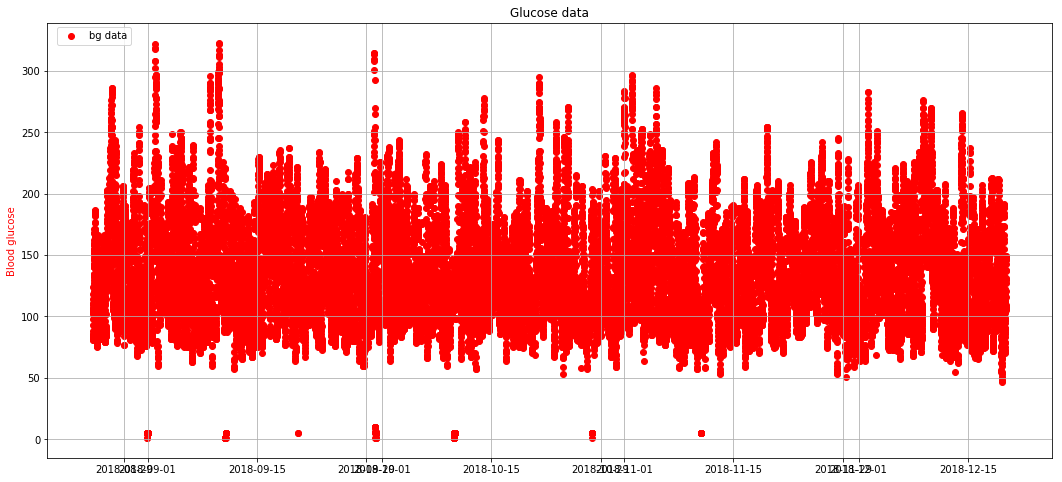

In [55]:
plot_gs_data(df_bg_20396154.rename(columns={"datetime":"time","sgv":"bg"}))

## Clustering-Kmeans+DTW

In [48]:
import pandas as pd
import _pickle as pickle
import numpy as np
import time
import math
import random
def DTWDistance(s1, s2, w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
            
    return math.sqrt(DTW[len(s1)-1, len(s2)-1])

def LB_Keogh(s1,s2,r):

    LB_sum=0
    for ind,i in enumerate(s1):
        lower_bound = upper_bound = 0
        radius = s2[(ind-r if ind-r>=0 else 0):(ind+r)]
        if len(radius)!=0:
            lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
            upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return math.sqrt(LB_sum)

def k_means_clust(data,num_clust,num_iter,w=5):
  
    centroids = random.sample(data, num_clust)
       
    counter=0
    for n in range(num_iter):
        print('round ', n)
        counter+=1
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
#                 print('i', i)
#                 print('j', j)
                lb = LB_Keogh(i,j,5)
                if lb<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind            
            assignments.setdefault(closest_clust,[])
            assignments[closest_clust].append(ind)
    
#         print('assignments', assignments)
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=np.zeros(len(data[0]))
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
                
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    return centroids, assignments


In [88]:
CLUSTER_NUM = 3
ROUND = 10

In [299]:
df_all.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,13.9,13.9,13.7,13.8,14.7,14.8,14.1,14.0,15.2,15.7,15.6,16.0,16.1
1,13.7,13.8,14.7,14.8,14.1,14.0,15.2,15.7,15.6,16.0,16.1,15.3,15.6
2,14.7,14.8,14.1,14.0,15.2,15.7,15.6,16.0,16.1,15.3,15.6,15.8,15.9
3,14.1,14.0,15.2,15.7,15.6,16.0,16.1,15.3,15.6,15.8,15.9,16.2,16.3
4,15.2,15.7,15.6,16.0,16.1,15.3,15.6,15.8,15.9,16.2,16.3,15.7,15.2


In [96]:
centroids_6, assigments_6 = k_means_clust(list(df_all.values), 6, ROUND)

round  0
round  1
round  2
round  3
round  4
round  5
round  6
round  7
round  8
round  9


In [296]:
centroids_8, assignments_8 = k_means_clust(list(df_all.values), 8, ROUND)

round  0
round  1
round  2
round  3
round  4
round  5
round  6
round  7
round  8
round  9


In [104]:
centroids_16, assignments_16 = k_means_clust(list(df_all.values), 16, ROUND)

round  0
round  1
round  2
round  3
round  4
round  5
round  6
round  7
round  8
round  9


In [90]:
centroids_3, assignments_3 = centroids, assignments

In [270]:
from random import sample 
def plot_clusters(cluster_num, centroids, assignments):
    fig, axs = plt.subplots(cluster_num, figsize=(15,cluster_num * 8))
#     plt.figure(figsize=(20,10))
    for key, value in assignments.items():
        samples = sample(value ,10)
        print(key, samples)   
    #     plt.subplot(key+1,1)
        for i in samples:
            axs[key].plot(df_all.iloc[:,:11].values[i])
    plt.savefig(str(cluster_num)+'_cluster.png', bbox_inches='tight')

0 [183174, 167166, 76214, 107826, 168889, 147313, 124744, 98321, 166166, 130111]
1 [9852, 191036, 174275, 10760, 167985, 31078, 30444, 120858, 114290, 24635]
2 [99000, 2930, 96218, 87140, 42644, 95299, 201823, 166347, 1037, 175981]


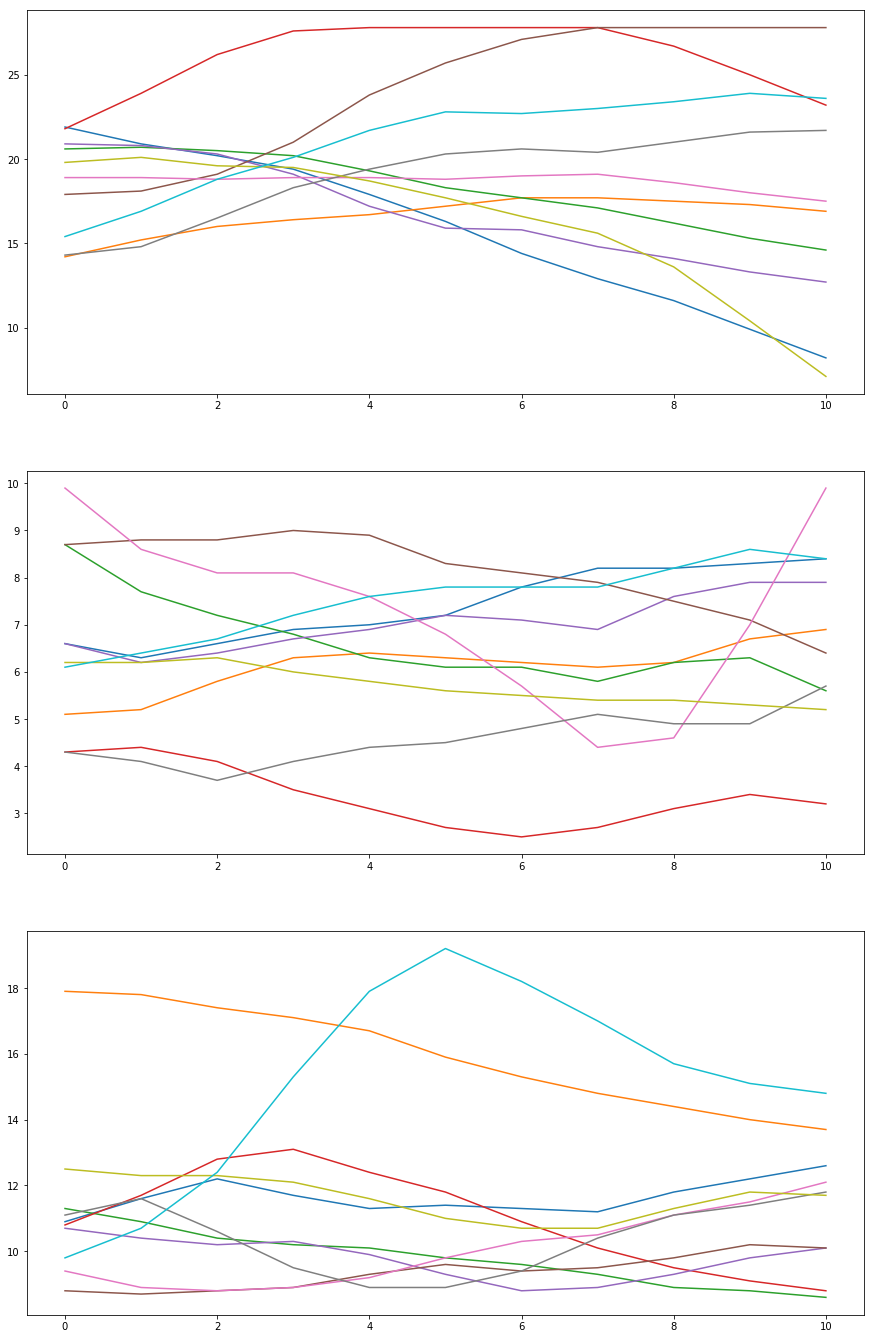

In [271]:
plot_clusters(3, centroids_3, assignments_3)

0 [176852, 172994, 59464, 39232, 24419, 110302, 174887, 66536, 127070, 132997]
1 [148479, 158181, 199672, 149285, 105052, 28702, 151085, 170939, 45529, 105773]
2 [100187, 57382, 18183, 110036, 103380, 6633, 3823, 112267, 182, 24831]
3 [119417, 198170, 37853, 14677, 33406, 171898, 83416, 22635, 123257, 30045]
4 [18464, 61659, 84484, 26692, 164896, 37675, 93211, 52846, 147824, 79333]
5 [44206, 187308, 103956, 167774, 110242, 39, 124307, 109524, 170221, 104281]


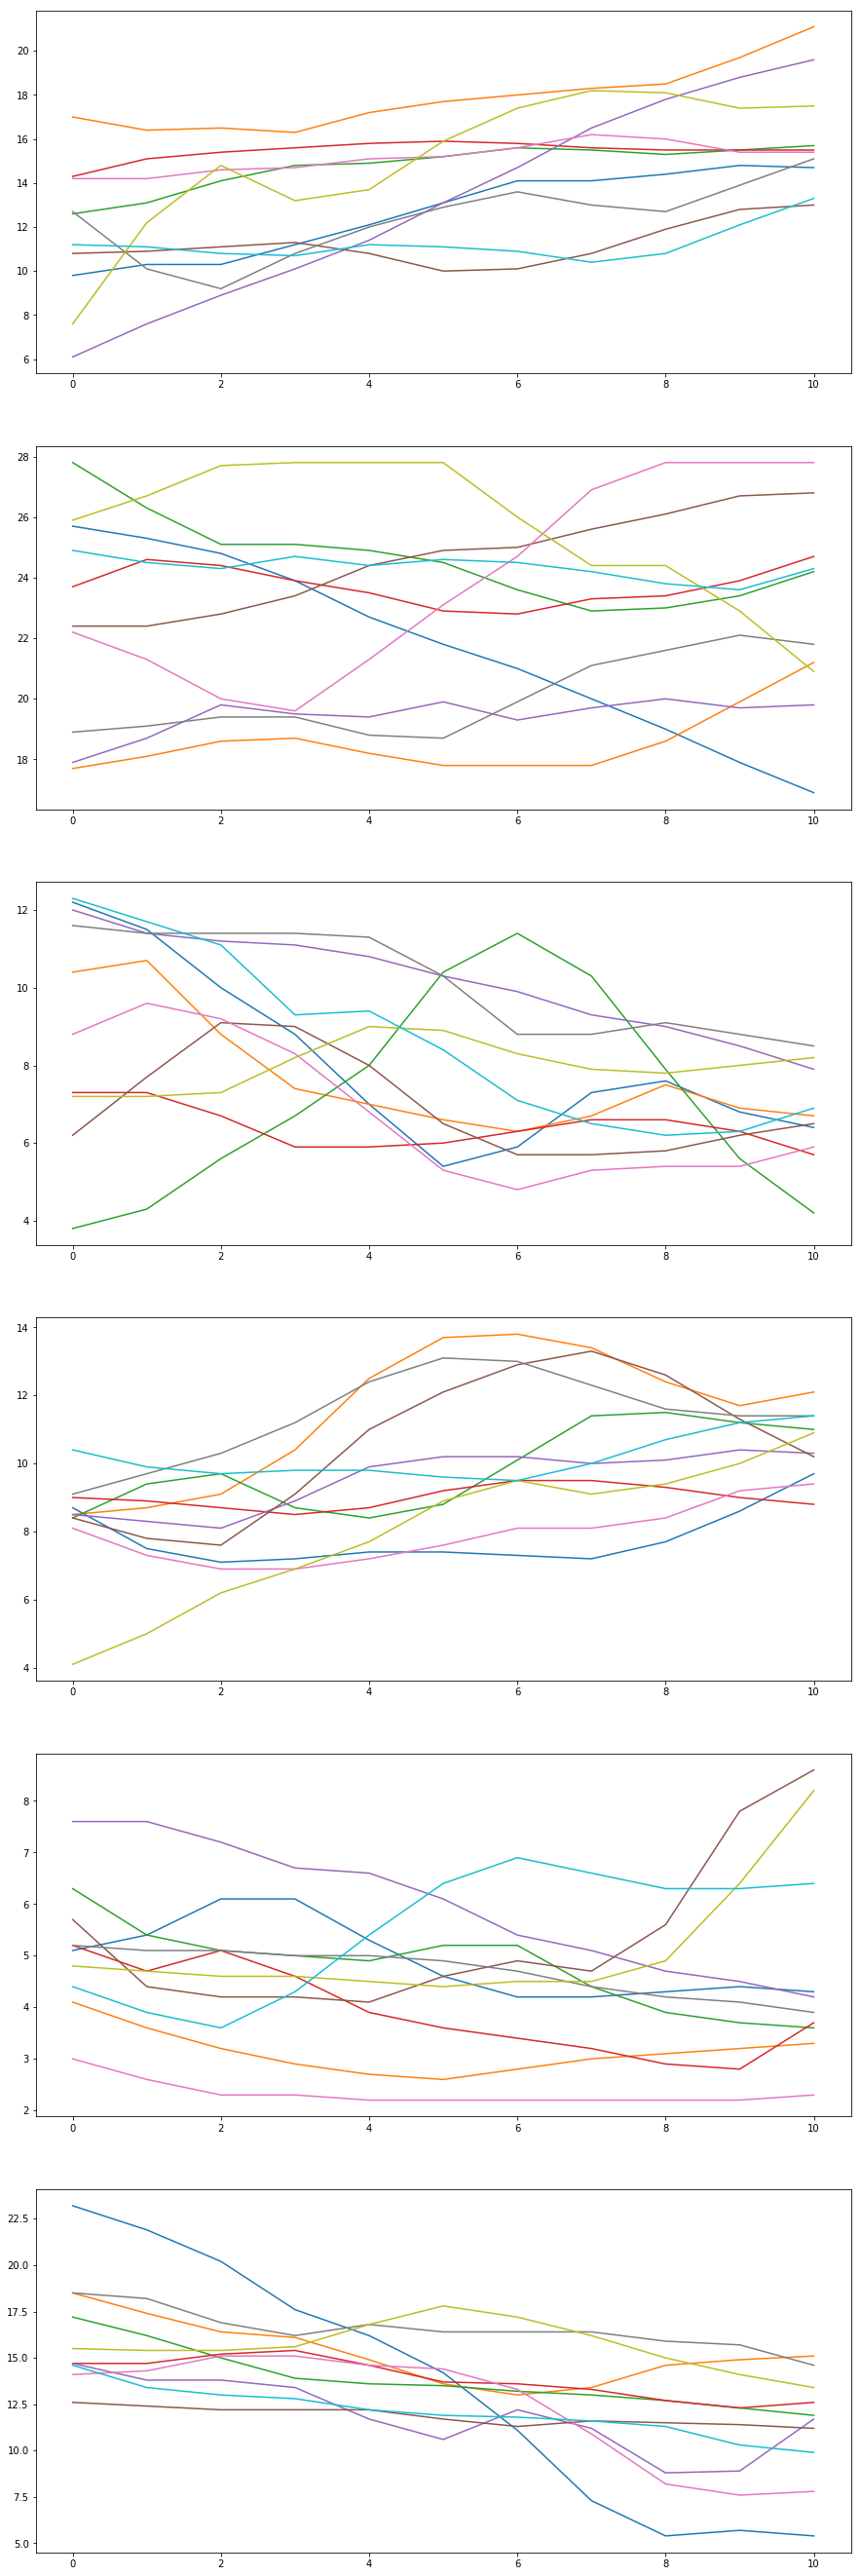

In [272]:
plot_clusters(6, centroids_6, assigments_6)

0 [126548, 110235, 85491, 36221, 244633, 187798, 195368, 29891, 24432, 193633]
1 [101600, 211510, 218592, 164836, 55842, 208474, 205284, 213648, 249141, 88572]
2 [78177, 167914, 39374, 23628, 257004, 15908, 20344, 184621, 169289, 245813]
3 [91345, 172555, 182596, 134982, 257148, 20949, 155219, 86105, 72956, 247563]
4 [190095, 230122, 178861, 226532, 11021, 136979, 36075, 226065, 213593, 103377]
5 [205261, 139059, 231280, 141333, 85070, 6802, 172404, 193392, 60914, 54035]
6 [136454, 190928, 116552, 255819, 46234, 76173, 199593, 52068, 252996, 96090]
7 [146550, 11980, 239878, 183573, 136621, 172178, 17093, 13673, 162782, 10743]


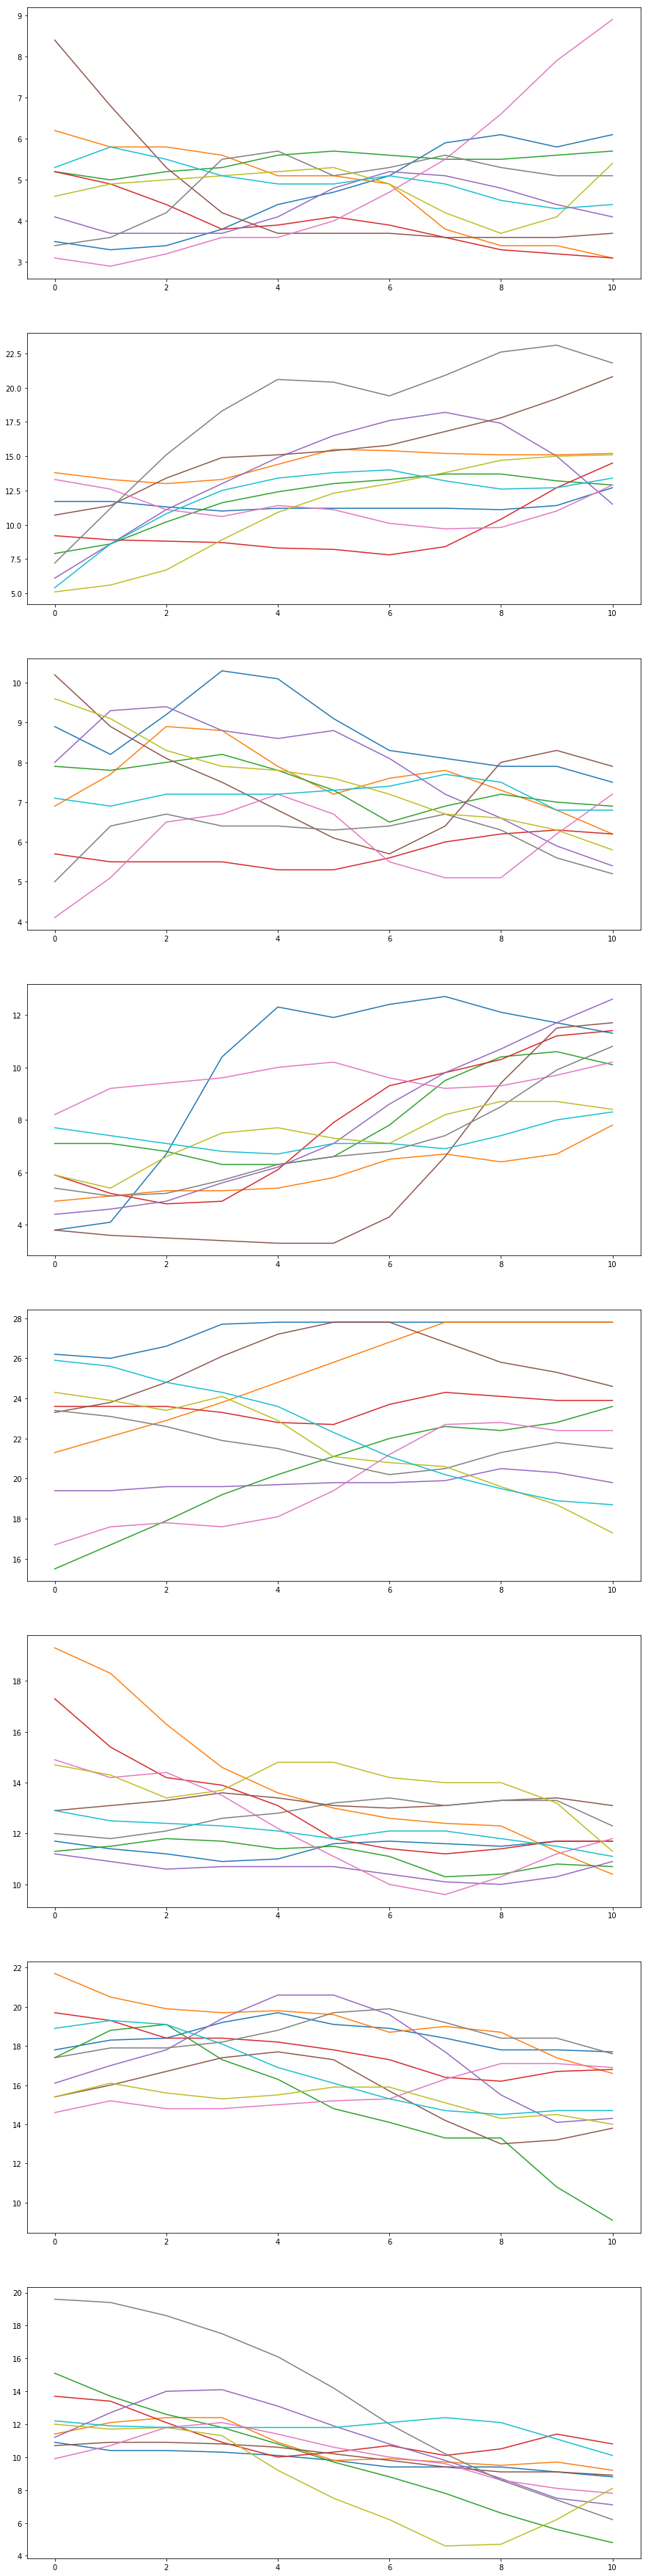

In [297]:
plot_clusters(8, centroids_8, assignments_8)

0 [172196, 114132, 37107, 137938, 171777, 134547, 136155, 143495, 97185, 67664]
1 [132163, 192305, 203967, 1427, 157228, 122188, 47751, 162358, 156282, 38383]
2 [156979, 189665, 164022, 149316, 114393, 40547, 72467, 196108, 135624, 26634]
3 [125135, 5395, 55850, 96522, 105764, 74185, 63893, 204590, 68326, 32948]
4 [19435, 206016, 127105, 123539, 202248, 102111, 192998, 86717, 145748, 59452]
5 [135261, 137471, 8321, 56600, 19917, 112077, 80525, 135613, 192601, 116798]
6 [39077, 134791, 51005, 177483, 134397, 80853, 76934, 123230, 178194, 26914]
7 [180329, 24078, 184875, 183041, 135642, 107046, 78649, 20927, 34793, 81418]
8 [197826, 100160, 40904, 148055, 153594, 171897, 153959, 92988, 81014, 112109]
9 [150826, 174637, 30219, 145998, 104968, 72077, 168339, 145971, 8540, 177758]
10 [148697, 15394, 161370, 149695, 109178, 174167, 40908, 148699, 38923, 189964]
11 [24457, 202592, 20223, 192739, 17448, 186712, 117431, 94489, 179137, 85497]
12 [151022, 158107, 159765, 159141, 148689, 174505, 8

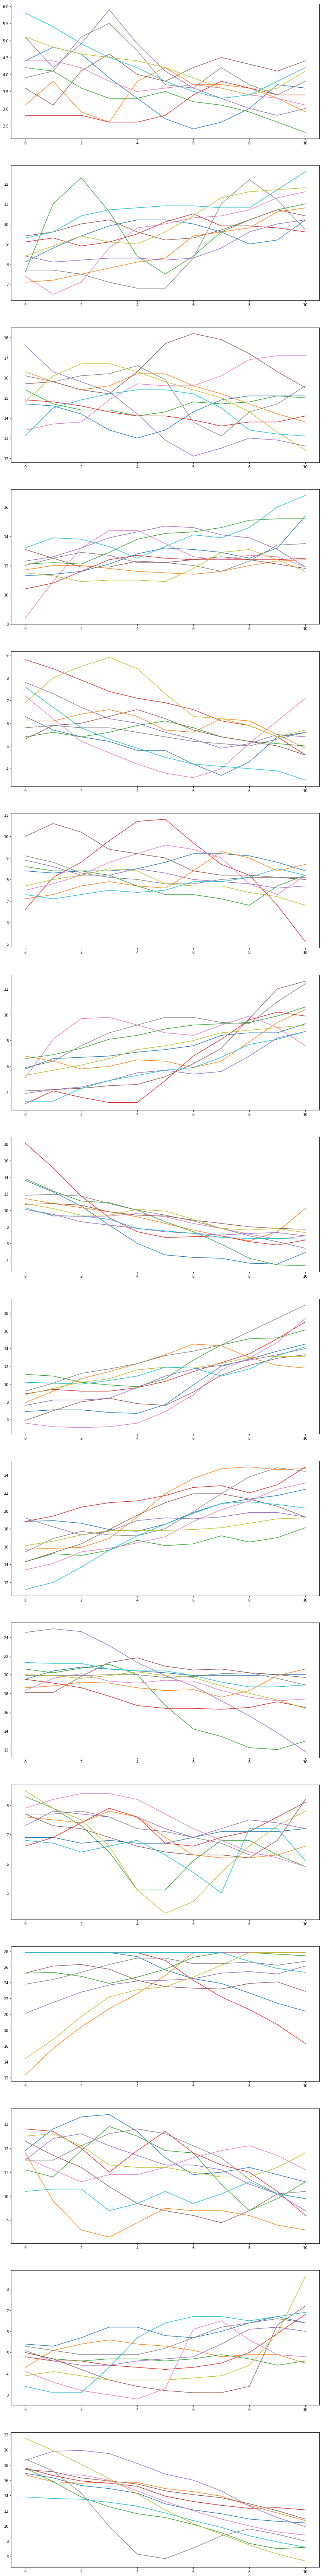

<Figure size 1440x720 with 0 Axes>

In [189]:
plot_clusters(16, centroids_16, assignments_16)

In [108]:
pickle.dump(centroids, open('all_clusters_centroids_4_10.pickle', 'wb'))

In [109]:
pickle.dump(assignments, open('all_clusters_asscignments_4_10.pickle', 'wb'))

In [ ]:
[len(_set) for _set in all_sets]

In [143]:
def stat_cluster_count(df_all, assignments, cluster_num):
    col = 'cluster_'+str(cluster_num)
    df_all[col]=-1
    for key, value in assignments.items():
        print('key=', key )
        for v in value:
            df_all.iloc[v, df_all.columns.get_loc(col)]=key
    return df_all       

In [174]:
df_all = stat_cluster_count(df_all, assigments_6, 6)

key= 0
key= 1
key= 2
key= 3
key= 4
key= 5


In [282]:
df_all = stat_cluster_count(df_all, assignments_8, 8)

key= 0
key= 1
key= 2
key= 3
key= 4
key= 5
key= 6
key= 7


In [177]:
df_all = stat_cluster_count(df_all, assignments_16, 16)

key= 0
key= 1
key= 2
key= 3
key= 4
key= 5
key= 6
key= 7
key= 8
key= 9
key= 10
key= 11
key= 12
key= 13
key= 14
key= 15


In [286]:
# The index end for each subset in df_all
index_points=[0 for i in all_sets]
index_points[0] = len(all_sets[0])
for i in range(1, len(all_sets)):
    index_points[i] = len(all_sets[i]) + index_points[i-1]    

In [287]:
def subet_marking(df_all, index_points):
    col = 'label'
    df_all[col]=-1
    col_num = df_all.columns.get_loc(col)
    df_all.iloc[:index_points[0],col_num]= 1
    for i in range(1, len(index_points)):
        df_all.iloc[index_points[i-1]:index_points[i], col_num] = i+1
    return df_all

In [288]:
df_all = subet_marking(df_all, index_points)

In [216]:
counts_values_6 = df_all.groupby('label')['cluster_6'].value_counts()

In [261]:
counts_values_3 = df_all.groupby('label')['cluster_3'].value_counts()

In [289]:
counts_values_8 = df_all.groupby('label')['cluster_8'].value_counts()

In [266]:
counts_values_16 = df_all.groupby('label')['cluster_16'].value_counts()

In [255]:
def write_count_values_to_file(filename, values):
    with open(filename, 'w') as f:
        for i in range(1, 131):
            f.write('No.'+str(i)+'\n')
            f.write(str(values[i].to_dict)+'\n')

In [290]:
counts_values_8

label  cluster_8
1      1            1021
       0             721
       2             660
       3             526
       7             272
                    ... 
130    4              44
       3              39
       7              33
       2              31
       6               3
Name: cluster_8, Length: 991, dtype: int64

In [267]:
write_count_values_to_file('cluster_16_marks.txt', counts_values_16)

In [249]:
# counts_values_3.columns=['label', 'c1','c2','c3']
counts_values_3 = pd.DataFrame(counts_values_3)
counts_values_3.head(30)
counts_values_3.to_json('counts_values_3.json')

In [ ]:
for i in range(130):
    print(i, df_all[df_all.label==i].cluster_6.value_counts())

In [317]:
df_all.to_csv('df_clusters.csv')

# Hierarchical clustering 

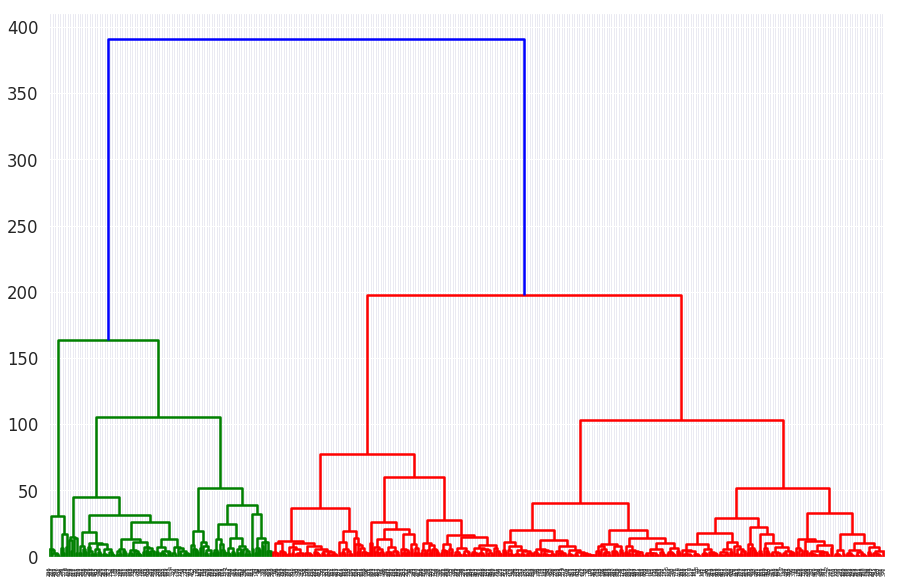

<Figure size 432x288 with 0 Axes>

In [375]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

Z = linkage(df_all.iloc[:, :11].sample(500), 'ward')
fig = plt.figure(figsize=(15, 10))
dn = dendrogram(Z)
plt.show()
plt.savefig('H-clustering_sample_100', bbox_inches='tight')

# Shapelets 

In [377]:
def generate_candidates(data, max_len=5, min_len=2):
    candidates, l = [], max_len
    while l >= min_len:
        for i in range(len(data)):
            time_serie, label = data[i][0], data[i][1]
            for k in range(len(time_serie)-l+1): candidates.append((time_serie[k:k+l], label))
        l -= 1
    return candidates


def check_candidate(data, shapelet):
    histogram = {} 
    for entry in data:
        # TODO: entropy pre-pruning in each iteration
        time_serie, label = entry[0], entry[1]
        d, idx = subsequence_dist(time_serie, shapelet)
        if d is not None:
            histogram[d] = [(time_serie, label)] if d not in histogram else histogram[d].append((time_serie, label))
    return find_best_split_point(histogram)


def calculate_dict_entropy(data):
    counts = {}
    for entry in data:
        if entry[1] in counts: counts[entry[1]] += 1
        else: counts[entry[1]] = 1
    return calculate_entropy(np.divide(list(counts.values()), float(sum(list(counts.values())))))


def find_best_split_point(histogram):
    histogram_values = list(itertools.chain.from_iterable(list(histogram.values())))
    prior_entropy = calculate_dict_entropy(histogram_values)
    best_distance, max_ig = 0, 0
    best_left, best_right = None, None
    for distance in histogram:
        data_left = []
        data_right = []
        for distance2 in histogram:
            if distance2 <= distance: data_left.extend(histogram[distance2])
            else: data_right.extend(histogram[distance2])
        ig = prior_entropy - (float(len(data_left))/float(len(histogram_values))*calculate_dict_entropy(data_left) + \
             float(len(data_right))/float(len(histogram_values)) * calculate_dict_entropy(data_right))
        if ig > max_ig: best_distance, max_ig, best_left, best_right = distance, ig, data_left, data_right
    return max_ig, best_distance, best_left, best_right


def manhattan_distance(a, b, min_dist=float('inf')):
    dist = 0
    for x, y in zip(a, b):
        dist += np.abs(float(x)-float(y))
        if dist >= min_dist: return None
    return dist

def calculate_entropy(probabilities):
    return sum([-prob * np.log(prob)/np.log(2) if prob != 0 else 0 for prob in probabilities])


def subsequence_dist(time_serie, sub_serie):
    if len(sub_serie) < len(time_serie):
        min_dist, min_idx = float("inf"), 0
        for i in range(len(time_serie)-len(sub_serie)+1):
            dist = manhattan_distance(sub_serie, time_serie[i:i+len(sub_serie)], min_dist)
            if dist is not None and dist < min_dist: min_dist, min_idx = dist, i
        return min_dist, min_idx
    else:
        return None, None


def find_shapelets_bf(data, max_len=100, min_len=1, plot=True, verbose=True):
    candidates = generate_candidates(data, max_len, min_len)
    bsf_gain, bsf_shapelet = 0, None
    if verbose: candidates_length = len(candidates)
    for idx, candidate in enumerate(candidates):
        gain, dist, data_left, data_right = check_candidate(data, candidate[0])
        if verbose: print(idx, '/', candidates_length, ":", gain, dist)
        if gain > bsf_gain:
            bsf_gain, bsf_shapelet = gain, candidate[0]
            if verbose:
                print('Found new best shapelet with gain & dist:', bsf_gain, dist, [x[1] for x in data_left], \
                                                                                   [x[1] for x in data_right])
            if plot:
                plt.plot(bsf_shapelet)
                plt.show()
            plt.show()
    return bsf_shapelet

def extract_shapelets(data, min_len=10, max_len=15, verbose=1):
#     _classes = np.unique([x[1] for x in data])
    shapelet_dict = {}
    for _class in _classes:
        print('Extracting shapelets for', _class)
        transformed_data = []
        for entry in data:
            time_serie =  entry
            if label == _class: transformed_data.append((time_serie, 1))
            else: transformed_data.append((time_serie, 0))
        shapelet_dict[_class] = find_shapelets_bf(transformed_data, max_len=max_len, min_len=min_len, plot=0, verbose=1)
    return shapelet_dict

In [397]:
shapetest_data=np.concatenate(inst1.to_numpy(), axis = 0)

In [485]:
from scipy import stats
from scipy.spatial import distance
import sys
import math

def computeGap(seq, dataset):
    dis = computeDistance(seq, dataset)
    dis = np.sort(dis)
    maxGap=0
    dt=0
    for l in range(len(dis)-1):
        d = (dis[l]+dis[l+1])/2
        DA, disA = filterdist(dis, min(dis), d)
        DB, disB= filterdist(dis, d, max(dis))
        r = len(DA)/len(DB)
        if ((1/4)<r and r <(1-1/4)):
            mA =  np.mean(dis[DA])
            mB = np.mean(dis[DB])
            sA = np.std(dis[DA])
            sB = np.std(dis[DB])
            gap = mB-sB-(mA+sA)
            if gap > maxGap:
                maxGap = gap
                dt = d
    return maxGap, dt

def computeDistance(seq, data):
    dis = [0]*len(data)
    seq = stats.zscore(seq)
    for i in range(len(data)):
        ts = data[i]
        dis[i] = sys.maxsize
        for j in range(len(ts)-len(seq)+1):
            z = stats.zscore(ts[j:j+len(seq)])
            d = distance.euclidean(z, seq)
            dis[i] = min(d, dis[i])
        
    return [x/math.sqrt(len(seq)) for x in dis]


def filterdist(dists, low, high):
    _indexs = []
    _dists = []
    for i in range(len(dists)):
        if dists[i] >= low and dists[i] <= high:
            _indexs.append(i)
            _dists.append(dists[i])
    return _indexs,_dists 
    

def extract_ushapelets(data, max_len=8, min_len = 5):
    shapelets = []
    ts = data[0]
#     print('ts', len(ts))
    while True:
        #count of candidate u-shapelets from ts
        cnt = 0 
        subs = [0]*len(data) 
        for sl in range(min_len, max_len):
            max_gap = -sys.maxsize
            index1 = 0
            for i in range(len(ts)-sl-1):
#                 print('i, i+sl', i, i+sl)
#                 print('ts',len(data))
                subs[cnt]=ts[i:i+sl]
                print('subs[cnt]', subs[cnt])
                gap, dt = computeGap(subs[cnt], data)
                if gap>max_gap:
                    gap = max_gap
                    index1=cnt                    
                cnt = cnt+1
#             print('index1',index1)
#             print('dt', dt)
#             index1 = max(gap)            
            shapelets.append(subs[index1])
            dis = computeDistance(subs[index1], data)
            
            DA, disDA = filterdist(dis, min(dis), dt)
#             print('lenDA:',len(DA))
#             print('shapelets', shapelets)
            if len(DA)==1: 
                return shapelets
            else:
                index2 = np.argmax(dis)
                ts = data[index2]
                theta = np.mean(disDA) + np.std(disDA)
                keep_indexs,keep_dists = filterdist(dis, theta, max(dis))
                data = [data[x] for x in keep_indexs]
    return shapelets

In [487]:
extract_ushapelets(all_sets[0][:200])

subs[cnt] [13.9, 13.9, 13.7, 13.8, 14.7]
subs[cnt] [13.9, 13.7, 13.8, 14.7, 14.8]
subs[cnt] [13.7, 13.8, 14.7, 14.8, 14.1]
subs[cnt] [10.1, 9.4, 8.3, 7.8, 7.6, 7.3]
subs[cnt] [9.4, 8.3, 7.8, 7.6, 7.3, 7.1]
subs[cnt] [6.6, 6.8, 7.0, 7.2, 7.3, 7.6, 7.7]
subs[cnt] [17.8, 17.2, 16.8, 16.0, 15.3]
subs[cnt] [17.2, 16.8, 16.0, 15.3, 14.8]
subs[cnt] [16.8, 16.0, 15.3, 14.8, 13.8]
subs[cnt] [11.5, 12.8, 13.2, 13.1, 12.9, 13.1]
subs[cnt] [12.8, 13.2, 13.1, 12.9, 13.1, 13.5]
subs[cnt] [8.4, 7.9, 7.5, 7.4, 7.4, 7.6, 7.4]
subs[cnt] [7.2, 7.1, 7.1, 7.1, 7.2]
subs[cnt] [7.1, 7.1, 7.1, 7.2, 7.4]
subs[cnt] [7.1, 7.1, 7.2, 7.4, 7.4]
subs[cnt] [12.6, 12.4, 12.2, 12.2, 12.2, 11.7]
subs[cnt] [12.4, 12.2, 12.2, 12.2, 11.7, 11.3]
subs[cnt] [15.2, 15.7, 15.6, 16.0, 16.1, 15.3, 15.6]
subs[cnt] [7.4, 7.3, 7.3, 7.3, 7.1]
subs[cnt] [7.3, 7.3, 7.3, 7.1, 7.1]
subs[cnt] [7.3, 7.3, 7.1, 7.1, 7.2]


[[13.7, 13.8, 14.7, 14.8, 14.1],
 [9.4, 8.3, 7.8, 7.6, 7.3, 7.1],
 [6.6, 6.8, 7.0, 7.2, 7.3, 7.6, 7.7],
 [16.8, 16.0, 15.3, 14.8, 13.8],
 [12.8, 13.2, 13.1, 12.9, 13.1, 13.5],
 [8.4, 7.9, 7.5, 7.4, 7.4, 7.6, 7.4],
 [7.1, 7.1, 7.2, 7.4, 7.4],
 [12.4, 12.2, 12.2, 12.2, 11.7, 11.3],
 [15.2, 15.7, 15.6, 16.0, 16.1, 15.3, 15.6],
 [7.3, 7.3, 7.1, 7.1, 7.2]]

# PCA & T-SNE

In [337]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

In [344]:
# Utility function to visualize the outputs of PCA and t-SNE

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    plt.
    return f, ax, sc, txts

In [ ]:
inst1 = df_all.iloc[:,:11]

### PCA

In [340]:
from sklearn.decomposition import PCA

time_start = time.time()

pca = PCA(n_components=4)
pca_result = pca.fit_transform(df_all.iloc[:,:11])

print ('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA done! Time elapsed: 0.30942654609680176 seconds


In [341]:
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

Variance explained per principal component: [0.89449104 0.08206098 0.01548756 0.00456889]


(<Figure size 864x864 with 1 Axes>,
 [Text(12.425296052596071, 4.307366018042212, '0'),
  Text(-14.124096420934793, 0.4051364318940381, '1'),
  Text(-20.316876367952673, -0.15939449612195977, '2'),
  Text(23.40308492845879, -2.319533403803512, '3'),
  Text(-6.74149060251667, -2.7779894212173213, '4'),
  Text(-3.80116975953539, 3.6624658835376938, '5'),
  Text(45.423371021861215, -0.4554370499886679, '6'),
  Text(5.4570717157915825, -2.5027348045859403, '7')])

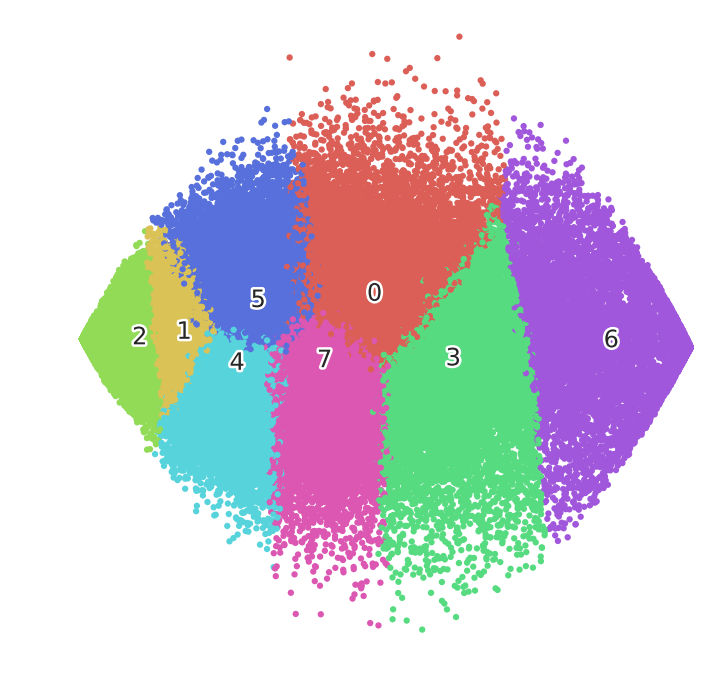

In [345]:
top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component

fashion_scatter(top_two_comp.values,df_all.cluster_8) # Visualizing the PCA output

### T-SNE 

In [346]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

fashion_tsne = TSNE(random_state=RS).fit_transform(df_all.iloc[:,:11])

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 3299.4083013534546 seconds


(<Figure size 864x864 with 1 Axes>,
 [Text(18.77948, 12.115058, '0'),
  Text(-2.2118435, -14.596231, '1'),
  Text(2.9172082, 13.470295, '2'),
  Text(31.087492, 19.207912, '3'),
  Text(-19.03624, 2.738893, '4'),
  Text(-14.555296, -7.2943287, '5'),
  Text(-17.189579, -35.155342, '6'),
  Text(2.5760038, 14.930216, '7')])

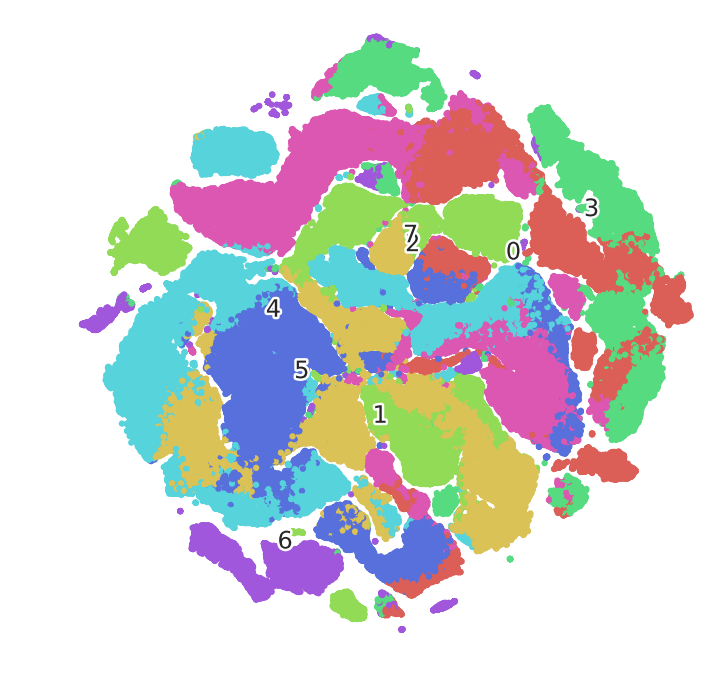

In [348]:
fashion_scatter(fashion_tsne, df_all.cluster_8)